![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNet_Original_Image.jpg)

![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNEt_Summary_Table.jpg)

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
import torchvision.datasets

In [4]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [6]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [7]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [8]:
X_train=X_train.reshape(50000,3,32,32)
X_train.shape, y_train.shape

(torch.Size([50000, 3, 32, 32]), torch.Size([50000]))

In [9]:
X_test=X_test.reshape(10000,3,32,32)
X_test.shape


torch.Size([10000, 3, 32, 32])

In [10]:
X_train.shape

torch.Size([50000, 3, 32, 32])

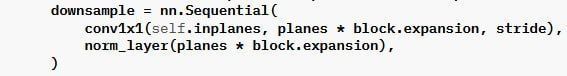

In [11]:
class ResNet18(torch.nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()

        self.conv1=torch.nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3)
        self.bn1= torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.act=torch.nn.ReLU(inplace=True)
        
        self.maxpool=torch.nn.MaxPool2d(kernel_size=3,stride=2,padding=1,dilation=1,ceil_mode=False)
        self.temp=0 # <--  using for skip connetcion x
      
        self.conv2= torch.nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.bn2=torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.conv3start=torch.nn.Conv2d(64,128, kernel_size=(3,3),stride=2,padding=1)
        self.bn3=torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3=torch.nn.Conv2d(128,128, kernel_size=(3,3),stride=1,padding=1)
        self.downsample1=torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False),
            torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )

        self.conv4start=torch.nn.Conv2d(128,256, kernel_size=(3,3),stride=2,padding=1)
        self.bn4=torch.nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4=torch.nn.Conv2d(256,256, kernel_size=(3,3),stride=1,padding=1)
        self.downsample2=torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False),
            torch.nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.conv5start=torch.nn.Conv2d(256,512, kernel_size=(3,3),stride=2,padding=1)
        self.bn5=torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5=torch.nn.Conv2d(512,512, kernel_size=(3,3),stride=1,padding=1)
        self.downsample3=torch.nn.Sequential(
            torch.nn.Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False),
            torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.avgpool=torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc=torch.nn.Linear(512,1000,bias=True)

    def forward(self,x):
        x=self.conv1(x)#1
        x=self.bn1(x)
        x=self.act(x)
        x=self.maxpool(x)

        self.temp=x #skip_connection

        x=self.conv2(x)#2
        x=self.bn2(x)
        x=self.act(x)
        x=self.conv2(x)#3
        x=self.bn2(x)

        x+=self.temp #end skil_connection
        self.temp=x# start skip_connection

        x=self.conv2(x)#4
        x=self.bn2(x)
        x=self.act(x)
        x=self.conv2(x)#5
        x=self.bn2(x)

        x+=self.temp
        self.temp=x

        x=self.conv3start(x)#6
        x=self.bn3(x)
        x=self.act(x)
        x=self.conv3(x)#7
        x=self.bn3(x)
        
        self.temp=self.downsample1(self.temp)

        x+=self.temp
        self.temp=x

        x=self.conv3(x)#8
        x=self.bn3(x)
        x=self.act(x)
        x=self.conv3(x)#9
        x=self.bn3(x)

        x+=self.temp
        self.temp=x

        x=self.conv4start(x)#10
        x=self.bn4(x)
        x=self.act(x)
        x=self.conv4(x)#11
        x=self.bn4(x)

        self.temp=self.downsample2(self.temp)
        x+=self.temp
        self.temp=x

        x=self.conv4(x)#12
        x=self.bn4(x)
        x=self.act(x)
        x=self.conv4(x)#13
        x=self.bn4(x)

        x+=self.temp
        self.temp=x

        x=self.conv5start(x)#14
        x=self.bn5(x)
        x=self.act(x)
        x=self.conv5(x)#15
        x=self.bn5(x)

        self.temp=self.downsample3(self.temp)
        x+=self.temp
        self.temp=x

        x=self.conv5(x)#16
        x=self.bn5(x)
        x=self.act(x)
        x=self.conv5(x)#17
        x=self.bn5(x)

        x+=self.temp
        self.temp=x

        x=self.avgpool(x)
        print(x.data.shape)
        x=self.fc(x)#18
        return x

net=ResNet18()

In [19]:
from torchvision.models import resnet18,ResNet18_Weights
model=resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
torch.save(model.state_dict(),"D:\\weights\\weig2.pth") 

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

In [21]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=3.0e-4)

In [24]:
#проверка дз
net.load_state_dict(torch.load("D:\\weights\\weig2.pth"), strict=False)
net.eval()

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3start): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downsample1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4start): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn4): Bat

In [25]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        print(X_batch.shape)
        preds = net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)

torch.Size([100, 3, 32, 32])
torch.Size([100, 512, 1, 1])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (51200x1 and 512x1000)

In [26]:

net.forward(X_test)

torch.Size([10000, 512, 1, 1])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (5120000x1 and 512x1000)